In [1]:
import netrc
netrc = netrc.netrc()
remoteHostName = "ooinet.oceanobservatories.org"
info = netrc.authenticators(remoteHostName)
username = info[0]
token = info[2]

In [2]:
import requests
import time

In [3]:
subsite = 'RS01SBPS'
node = 'PC01A'
sensor = '4A-CTDPFA103'
method = 'streamed'  #cabled data
stream = 'ctdpf_optode_sample'
beginDT = '2017-08-21T07:00:00.000Z' #begin of first deployment
endDT = '2017-08-22T07:00:00.000Z'

In [4]:
base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

data_request_url ='/'.join((base_url,subsite,node,sensor,method,stream))
params = {
    'beginDT':beginDT,
    'endDT':endDT,   
}
r = requests.get(data_request_url, params = params, auth=(username, token))
data = r.json()

In [5]:
print(data['allURLs'][0])

https://opendap.oceanobservatories.org/thredds/catalog/ooi/kasm@uw.edu/20180222T210210-RS01SBPS-PC01A-4A-CTDPFA103-streamed-ctdpf_optode_sample/catalog.html


In [6]:
print(data['allURLs'][1])

https://opendap.oceanobservatories.org/async_results/kasm@uw.edu/20180222T210210-RS01SBPS-PC01A-4A-CTDPFA103-streamed-ctdpf_optode_sample


In [7]:
%%time
check_complete = data['allURLs'][1] + '/status.txt'
for i in range(1800): 
    r = requests.get(check_complete)
    if r.status_code == requests.codes.ok:
        print('request completed')
        break
    else:
        time.sleep(1)

request completed
CPU times: user 557 ms, sys: 40.3 ms, total: 598 ms
Wall time: 32.4 s


In [9]:
import re
import xarray as xr
import pandas as pd
import os

In [15]:
url = data['allURLs'][0]
#url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/ooidatateam@gmail.com/20180221T030103-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/catalog.html'
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]

In [16]:
datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/kasm@uw.edu/20180222T210210-RS01SBPS-PC01A-4A-CTDPFA103-streamed-ctdpf_optode_sample/deployment0004_RS01SBPS-PC01A-4A-CTDPFA103-streamed-ctdpf_optode_sample_20170821T070000.459970-20170822T065959.983696.nc']

In [17]:
ds = xr.open_mfdataset(datasets)
ds = ds.swap_dims({'obs': 'time'})
ds = ds.chunk({'time': 100})
ds

<xarray.Dataset>
Dimensions:                (time: 86400)
Coordinates:
    obs                    (time) int32 dask.array<shape=(86400,), chunksize=(100,)>
  * time                   (time) datetime64[ns] 2017-08-21T07:00:00.459969536 ...
    lat                    (time) float64 dask.array<shape=(86400,), chunksize=(100,)>
    lon                    (time) float64 dask.array<shape=(86400,), chunksize=(100,)>
Data variables:
    deployment             (time) int32 dask.array<shape=(86400,), chunksize=(100,)>
    id                     (time) |S64 dask.array<shape=(86400,), chunksize=(100,)>
    conductivity           (time) float64 dask.array<shape=(86400,), chunksize=(100,)>
    driver_timestamp       (time) datetime64[ns] dask.array<shape=(86400,), chunksize=(100,)>
    ingestion_timestamp    (time) datetime64[ns] dask.array<shape=(86400,), chunksize=(100,)>
    internal_timestamp     (time) datetime64[ns] dask.array<shape=(86400,), chunksize=(100,)>
    oxy_calphase           (time)

In [19]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np

//anaconda/lib/python3.5/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


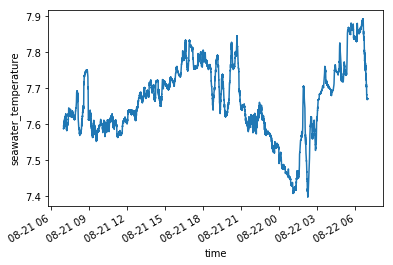

In [20]:
ds['seawater_temperature'].plot()
plt.show()

In [ ]:
ds['seawater_temperature'].plot()
plt.show()

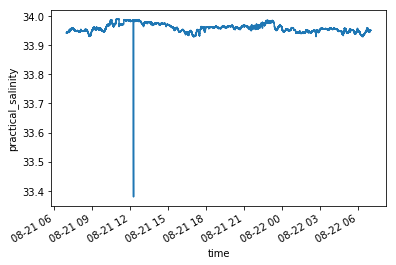

In [34]:
ds['practical_salinity'].plot()
plt.show()

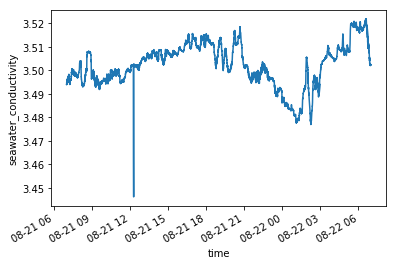

In [35]:
ds['seawater_conductivity'].plot()
plt.show()

In [23]:
import seawater as sw

In [29]:
pres = ds['seawater_pressure']
temp = ds['seawater_temperature']
lat = ds.attrs['geospatial_lat_min']

In [30]:
depth = sw.dpth(pres, lat)

In [31]:
depth

array([ 194.17403103,  194.17403103,  194.17296837, ...,  194.22213425,
        194.22321099,  194.22214833])

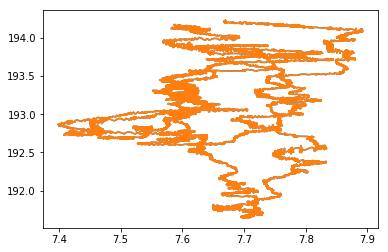

In [33]:
plt.plot(temp, depth)
plt.show()